Epoch 1/50


/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0630
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0072
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0059
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0052
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0018
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 16/50
63/

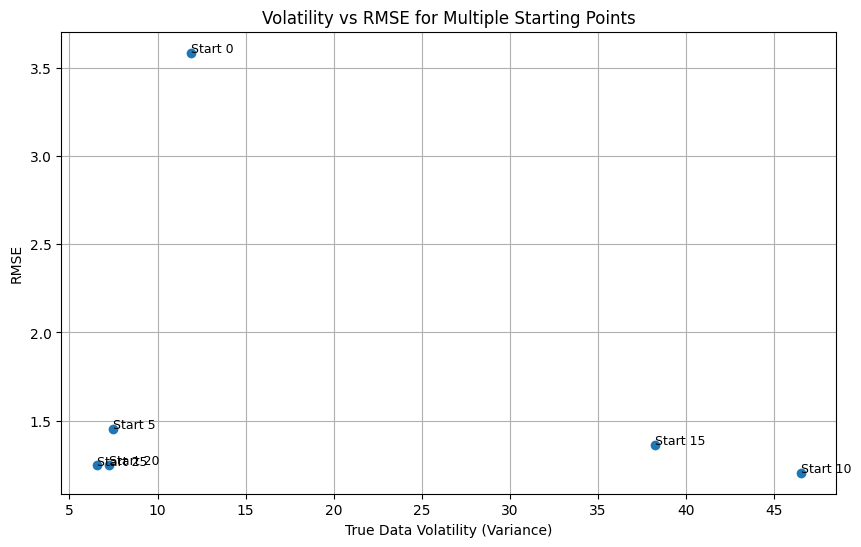

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Layer, GRUCell
from tensorflow.keras.models import Sequential

# Define EGRU Cell
class EGRUCell(GRUCell):
    def __init__(self, units, decay_initializer="zeros", **kwargs):
        super().__init__(units, **kwargs)
        self.decay_initializer = decay_initializer

    def build(self, input_shape):
        super().build(input_shape)
        self.decay = self.add_weight(
            shape=(self.units,),
            initializer=self.decay_initializer,
            name="decay",
            trainable=True
        )

    def call(self, inputs, states, training=None):
        output, [hidden_state] = super().call(inputs, states, training=training)
        decayed_hidden_state = tf.exp(-tf.abs(self.decay)) * hidden_state
        return decayed_hidden_state, [decayed_hidden_state]

# Define EGRU Layer
class EGRU(Layer):
    def __init__(self, units, return_sequences=False, return_state=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.cell = EGRUCell(units)

    def call(self, inputs, initial_state=None, training=None):
        rnn = tf.keras.layers.RNN(self.cell, return_sequences=self.return_sequences, return_state=self.return_state)
        return rnn(inputs, initial_state=initial_state, training=training)

# Create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Split dataset
def split_data(df, training_period, train_ratio=0.8):
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=["Close"]))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=["Close"]).columns, index=df.index)
    scaled_data["Close"] = df["Close"]

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data["Close"] = target_scaler.fit_transform(df["Close"].values.reshape(-1, 1)).ravel()

    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    X_train = train_data.drop(columns=["Close"])
    y_train = train_data["Close"]
    X_test = test_data.drop(columns=["Close"])
    y_test = test_data["Close"]

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Train EGRU model
def train_egru(X_train, y_train, input_shape):
    model = Sequential([
        EGRU(units=50, return_sequences=True),
        EGRU(units=50, return_sequences=False),
        tf.keras.layers.Dense(units=25, activation="relu"),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")

    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    model.fit(X_train, y_train.values, epochs=50, batch_size=32, verbose=1)
    return model

# Evaluate and visualize predictions
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, feature_scaler, target_scaler):
    errors = []
    volatilities = []
    start_indices = range(0, 30, 5)

    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict
        context_idx = start_idx - 15
        X_context = X_test.iloc[context_idx:start_idx]
        X_sub = X_test.iloc[start_idx:end_idx]
        y_true = y_test.iloc[start_idx:end_idx]

        X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1], 1))
        predictions = model.predict(X_sub)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        y_true_unscaled = target_scaler.inverse_transform(y_true.values.reshape(-1, 1)).ravel()

        rmse = math.sqrt(mean_squared_error(y_true_unscaled, predictions))
        errors.append(rmse)
        true_volatility = y_true_unscaled.var()
        volatilities.append(true_volatility)

        plt.figure(figsize=(10, 6))
        plt.plot(test_index[start_idx:end_idx], y_true_unscaled, label="True Data", color="green")
        plt.plot(test_index[start_idx:end_idx], predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("TSLA_pred/lstm-egru/80_20", exist_ok=True)
        plt.savefig(f"TSLA_pred/lstm-egru/80_20/start_{start_idx}.png")
        plt.close()

    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, errors, marker="o")
    for i, idx in enumerate(start_indices):
        plt.text(volatilities[i], errors[i], f"Start {idx}", fontsize=9)
    plt.xlabel("True Data Volatility (Variance)")
    plt.ylabel("RMSE")
    plt.title("Volatility vs RMSE for Multiple Starting Points")
    plt.grid(True)
    plt.savefig("TSLA_pred/lstm-egru/80_20/volatility_vs_rmse.png")
    plt.show()

# Main function
def main():
    training_period = 15
    n_days_to_predict = 15
    path = "TSLA.csv"

    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)
    input_shape = (X_train.shape[1], 1)
    model = train_egru(X_train, y_train, input_shape)
    evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, feature_scaler, target_scaler)

# Run
if __name__ == "__main__":
    main()


In [3]:
scaler.inverse_transform(scaled_data[len(x_train)-20:len(x_train)])[-3:]

NameError: name 'scaler' is not defined